In [1]:
import numpy as np
from scipy.constants import Boltzmann as k
from numpy.typing import NDArray
from typing import List
import matplotlib.pyplot as plt
from numba import jit
import numba as nb
from scipy.ndimage import convolve, generate_binary_structure

In [2]:
N = 3
@nb.njit(parallel=True)
def generate_lattice(L: int, p: float = 0.5) -> np.ndarray:
    init_lattice = np.empty((L, L), dtype=np.float32)
    for i in nb.prange(L):
        for j in range(L):
            # Generate a random number for each element
            random_value = np.random.random()
            if random_value >= p:
                init_lattice[i, j] = 1
            else:
                init_lattice[i, j] = -1
    return init_lattice

state = generate_lattice(10, 0.5)

In [3]:
print(state)

[[ 1. -1.  1.  1.  1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  1.  1.  1.  1. -1. -1. -1.]
 [ 1. -1.  1.  1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1. -1. -1.]
 [-1.  1. -1.  1. -1. -1.  1. -1.  1.  1.]
 [-1.  1. -1. -1.  1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1. -1. -1.  1.  1.]
 [-1.  1. -1. -1. -1.  1.  1. -1.  1.  1.]]


In [4]:
def energy_naive(lattice: np.ndarray) -> int:
    H = 0
    for row in lattice:
        H += (np.sum(row[:-1] * row[1:]) + row[0]*row[-1])
    
    for col in lattice.T:
        H += (np.sum(col[:-1] * col[1:]) + col[0]*col[-1])

    return -H


In [5]:
def energy_conv(lattice: np.ndarray) -> int:
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode = "wrap")
    return arr.sum()/2

In [6]:
import numpy as np
from numba import jit

@jit(nopython=True)  # Use the nopython mode for better performance
def energy_numba(lattice: np.ndarray) -> int:
    H = 0
    N = lattice.shape[0]
    M = lattice.shape[1]

    # Calculate horizontal interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            right_neighbor = (j + 1) % M  # Wrap around horizontally
            H += lattice[i, j] * lattice[i, right_neighbor]

    # Calculate vertical interactions with periodic boundary conditions
    for i in range(N):
        for j in range(M):
            down_neighbor = (i + 1) % N  # Wrap around vertically
            H += lattice[i, j] * lattice[down_neighbor, j]

    return -H

In [77]:
import numba as nb
@jit(parallel=True)
def energy(lattice: np.ndarray) -> int:
    N, M = lattice.shape  # Assuming a square lattice for simplicity
    H = 0.0
    
    # Loop over all elements to calculate horizontal and vertical interactions
    # Parallelize the outer loop
    for i in nb.prange(N):
        for j in range(M):
            right_neighbor = (j + 1) % M
            down_neighbor = (i + 1) % N
            
            # Periodic boundary conditions are handled by wrapping index
            H += lattice[i, j] * (lattice[i, right_neighbor] + lattice[down_neighbor, j])
    
    return -H

In [8]:
print(energy(state))

12.0


In [9]:
print(energy_numba(state))

12.0


In [10]:
print(energy_naive(state))

12.0


In [11]:
print(energy_conv(state))

12.0


In [12]:
def plot_lattice(lattice):
    plt.imshow(lattice, cmap = plt.cm.colors.ListedColormap(['#0000FF', '#FF0000']))

In [13]:
@jit(nopython=True)
def delta_energy(initial_lattice: np.ndarray, spin_to_flip: tuple[int, int]) -> int:
    #Calculates E_new - E_old
    L = initial_lattice.shape[0]
    sum_of_neighbors = 0
    x,y = spin_to_flip[0], spin_to_flip[1]

    sum_of_neighbors = (initial_lattice[(x + 1)%L, y] +
                        initial_lattice[(x - 1)%L, y] +
                        initial_lattice[x, (y + 1)%L] +
                        initial_lattice[x, (y - 1)%L])
     
    return 2 * sum_of_neighbors * initial_lattice[x, y]


In [14]:
@jit(nopython=True)
def flip_spin_in_lattice(lattice: np.ndarray, spin: tuple[int,int]) -> np.ndarray:
    #given a lattice l, return a new lattice l'
    new_lattice = lattice.copy()
    new_lattice[spin] *= -1
    return new_lattice

In [15]:
@jit(nopython=True)
def flip_random_spin(lattice: np.ndarray) -> tuple[int, int]:
    L = lattice.shape[0]
    x, y = np.random.randint(0, L), np.random.randint(0, L)
    return (x,y)

In [16]:
cand_spin = flip_random_spin(state)
print(delta_energy(state, cand_spin), energy(flip_spin_in_lattice(state, cand_spin)) - energy(state))

4.0 4.0


In [17]:
def magnetization(lattice: np.ndarray) -> float:
    return np.sum(lattice)

In [18]:
@jit(nopython=True)
def sampler(type: str,init_dist: np.ndarray, beta: float, num_iters: int, sweep_size: int = 50):
    fixed_time_samples = []
    updated_samples = []
    sample = init_dist.copy()
    for i in range(num_iters):
        candidate_spin = flip_random_spin(sample)
        if type == "mh":
            acceptance_prop = min(1, np.exp(-beta * delta_energy(sample, candidate_spin)))
        elif type == "gibbs":
            acceptance_prop = 1/(1 + 1/np.exp(-beta * delta_energy(sample, candidate_spin)))
        else:
            print("error, sampler type must either be mh or gibbs")
            break
        if (acceptance_prop > np.random.random()):  
            sample = flip_spin_in_lattice(sample, candidate_spin)
            updated_samples.append(sample)
        if i % sweep_size == 0:
            fixed_time_samples.append(sample)
    return fixed_time_samples, updated_samples
            

In [19]:
N, p, beta = 50, 0.5, 0.44

In [20]:
mh_fixed_time_res, mh_updated_res = sampler('mh', generate_lattice(N, p), beta, 2_000_000)
print(len(mh_fixed_time_res), len(mh_updated_res))

40000 416750


In [21]:
gibbs_fixed_time_res, gibbs_updated_res = sampler('gibbs', generate_lattice(N, p), beta, 2_000_000)
print(len(gibbs_fixed_time_res), len(gibbs_updated_res))


40000 325628


In [22]:
def plot_magnetization_squared(samples: list):
    samples = np.array(samples)
    magnetization_squared_of_samples = (np.mean(samples, axis = (1,2)) ** 2)
    plt.plot(magnetization_squared_of_samples)
    plt.title("Magnetization density squared")

In [23]:
def plot_magnetization(samples: list):
    samples = np.array(samples)
    magnetization_of_samples = (np.mean(samples, axis = (1,2)))
    plt.plot(magnetization_of_samples)
    plt.title("Magnetization density")

In [24]:
def plot_energy(samples: list):
    L = samples[0].shape[0]
    energy_of_samples = [energy(sample)/(L**2) for sample in samples]
    plt.plot(energy_of_samples)
    plt.title("Energy density")

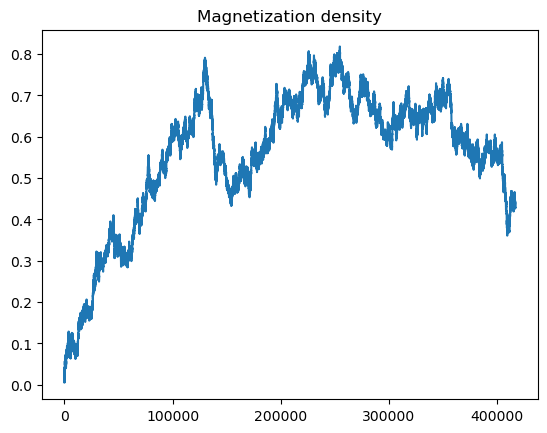

In [36]:
plot_magnetization(mh_updated_res)

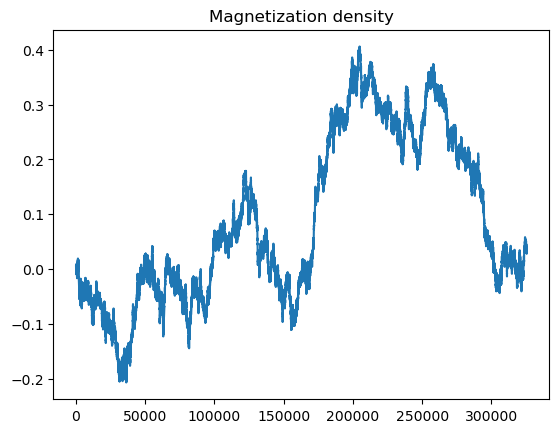

In [26]:
plot_magnetization(gibbs_updated_res)

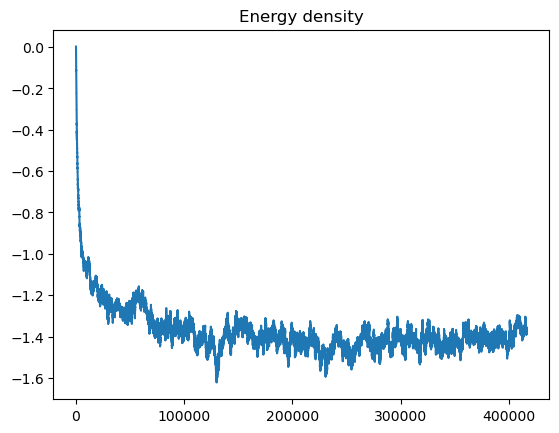

In [27]:
plot_energy(mh_updated_res)

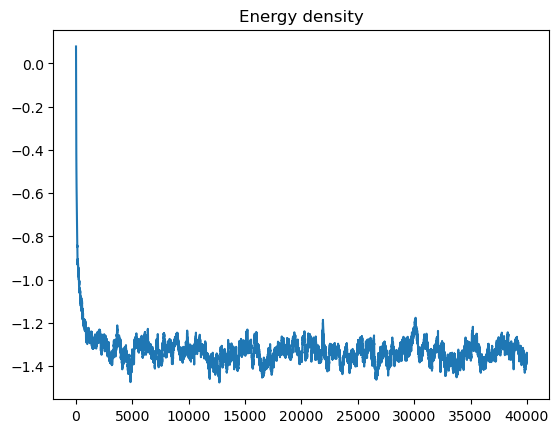

In [28]:
plot_energy(gibbs_fixed_time_res)

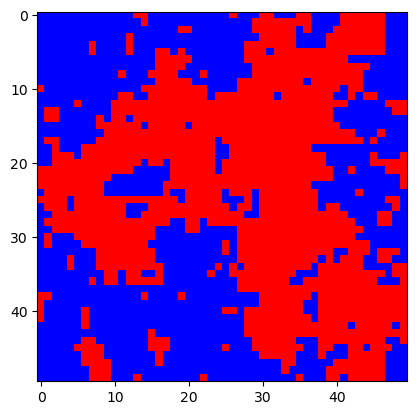

In [31]:
plot_lattice(gibbs_updated_res[-1])

In [37]:
def average_magnetization(samples: list) -> float:
    n = len(samples)
    converged_samples = np.array(samples[-n // 5:])
    magnetization_samples = (np.mean(converged_samples, axis = (1,2)) ** 2)
    return np.mean(magnetization_samples)

In [38]:
average_magnetization(gibbs_updated_res)

0.027957585

In [39]:
average_magnetization(mh_updated_res)

0.34929302

In [51]:
def average_energy(samples: list) -> float:
    L = samples[0].shape[0]
    n = len(samples)
    converged_samples = np.array(samples[-n // 5:])
    energy_of_samples = np.array([energy(sample)/(L**2) for sample in converged_samples])
    return np.mean(energy_of_samples)

In [49]:
average_energy(gibbs_updated_res)

-3346.3316647729016

In [42]:
average_energy(mh_updated_res)

-3519.787306538692

In [72]:
betas = [0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 1]
n_vals = [6, 10, 16, 25]

In [67]:
grid_mh_energy = []
grid_mh_mag = []
grid_gibbs_energy = []
grid_gibbs_mag = []

for n in n_vals:
    n_grid_mh_energy = []
    n_grid_mh_mag = []
    n_grid_gibbs_energy = []
    n_grid_gibbs_mag = []
    
    for beta in betas:
        n_grid_mh_fixed_time_samples, n_grid_mh_updated_samples = sampler('mh', generate_lattice(n, 0.5), beta, 2_000_000)
        n_grid_gibbs_fixed_time_samples, n_grid_gibbs_updated_samples = sampler('gibbs', generate_lattice(n, 0.5), beta, 2_000_000)
        print(beta, n, len(n_grid_mh_updated_samples), len(n_grid_gibbs_updated_samples))
        n_grid_mh_energy.append(average_energy(n_grid_mh_updated_samples))
        n_grid_mh_mag.append(average_magnetization(n_grid_mh_updated_samples))
        n_grid_gibbs_energy.append(average_energy(n_grid_gibbs_updated_samples))
        n_grid_gibbs_mag.append(average_magnetization(n_grid_gibbs_updated_samples))

    grid_mh_energy.append(n_grid_mh_energy)
    grid_mh_mag.append(n_grid_mh_mag)

    grid_gibbs_energy.append(n_grid_gibbs_energy)
    grid_gibbs_mag.append(n_grid_gibbs_mag)

0 6 2000000 1000715
0.1 6 1698471 960616
0.2 6 1383207 847573
0.3 6 1019534 661246
0.35 6 785587 533904
0.4 6 513075 367039
0.42 6 412890 303745
0.44 6 326662 249574
0.46 6 258387 201389
0.48 6 199198 165716
0.5 6 157232 131802
0.55 6 92085 77642
0.6 6 52519 48123
0.7 6 19313 19432
0.8 6 7913 8036
0.9 6 3509 3462
1 6 1443 1460
0 10 2000000 1001219
0.1 10 1698073 960785
0.2 10 1383021 848946
0.3 10 1043532 675327
0.35 10 843093 561747
0.4 10 595135 406973
0.42 10 471401 337735
0.44 10 371340 277264
0.46 10 269066 207965
0.48 10 201626 165635
0.5 10 155790 132860
0.55 10 88745 77077
0.6 10 52046 48035
0.7 10 19749 19318
0.8 10 8552 8166
0.9 10 3498 3478
1 10 1567 1617
0 16 2000000 999432
0.1 16 1697553 960318
0.2 16 1383525 848822
0.3 16 1044779 678185
0.35 16 858740 568856
0.4 16 624567 433893
0.42 16 504205 347853
0.44 16 369232 277379
0.46 16 269354 212759
0.48 16 206046 169777
0.5 16 157977 137122
0.55 16 91344 78224
0.6 16 52319 48951
0.7 16 20073 19541
0.8 16 9466 8277
0.9 16 11212

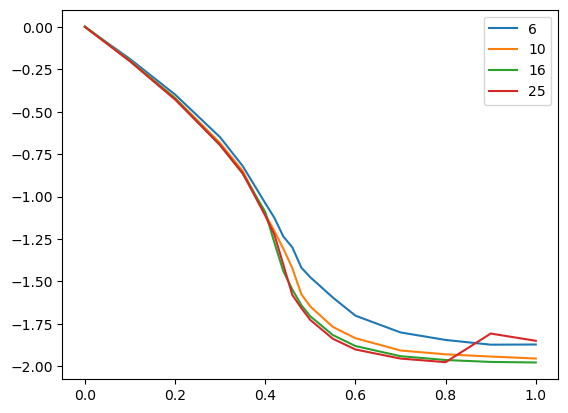

In [73]:
for energy,n in zip(grid_mh_energy, n_vals):
    plt.plot(betas, energy, label = n)

plt.legend()
plt.show()

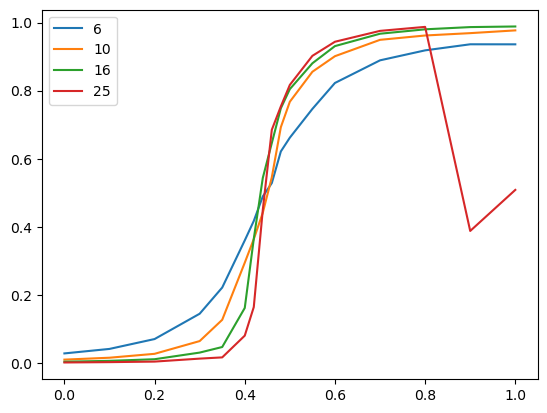

In [74]:
for mag, n in zip(grid_mh_mag, n_vals):
    plt.plot(betas, mag, label = n)

plt.legend()
plt.show()

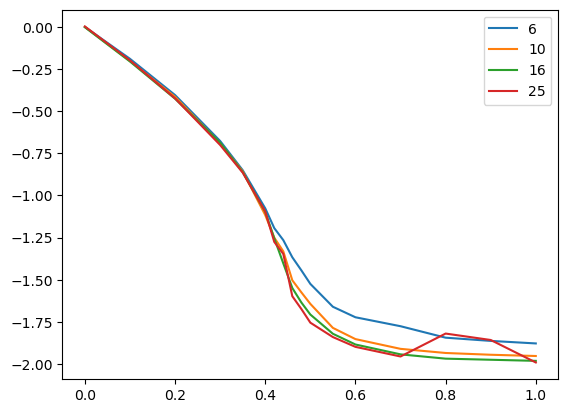

In [75]:
for energy,n in zip(grid_gibbs_energy, n_vals):
    plt.plot(betas, energy, label = n)

plt.legend()
plt.show()

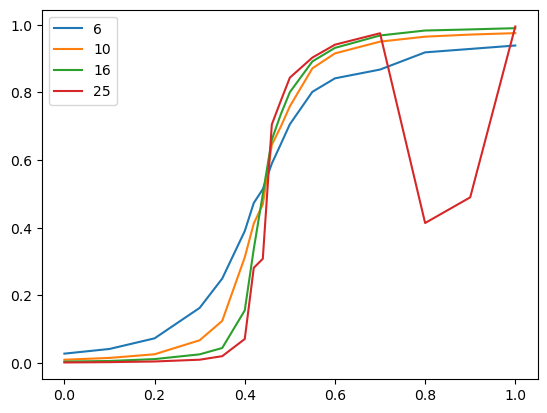

In [81]:
for mag, n in zip(grid_gibbs_mag, n_vals):
    plt.plot(betas, mag, label = n)

plt.legend()
plt.show()

In [78]:
def correlation(samples: list, i: tuple[int,int], j: tuple[int,int]) -> float:
    n = len(samples)
    converged_samples = np.array(samples[-n // 5:])
    sigma_is = converged_samples[:, i[0], i[1]]
    sigma_js = converged_samples[:, j[0], j[1]]
    demeaned_sigma_is = sigma_is - np.mean(sigma_is)
    demeaned_sigma_js = sigma_js - np.mean(sigma_js)
    return (demeaned_sigma_is * demeaned_sigma_js)

In [98]:
sixteen_gibbs_fixed_time_res , sixteen_gibbs_updated_res = sampler('gibbs', generate_lattice(16, 0.5), 0.44, 3_000_000)

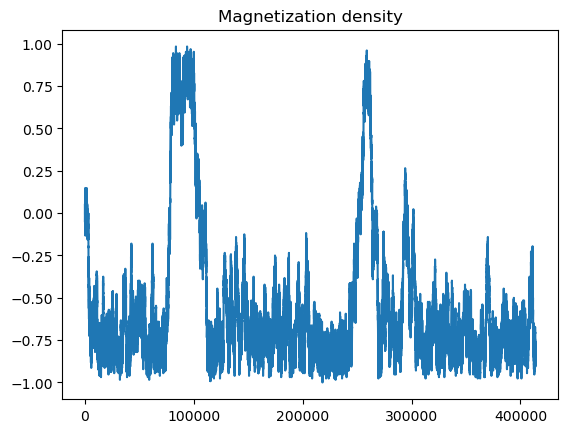

In [99]:
plot_magnetization(sixteen_gibbs_updated_res)

In [100]:
def euclidean_distance(i: tuple[int,int], j: tuple[int,int]) -> float:
    return np.sqrt((i[0] - j[0])**2 + (i[1] - j[1])**2)